The Dataset: SurGen SR386 Cohort (SR386_labels.csv) | Radit Srisathaporn (Vic)

Last Update: 15/11/2025

In [ ]:
#ANN Analysis for SR386
#This Google Collab walks through the complete process of building, evaluating, and improving a Neural Network to predict 5-year survival for colorectal cancer patients.

#Step 0: Setup Environment

#0.1: Mount Google Drive
#Connect Colab to your Google Drive to access the uploaded file (SR386_labels.csv).
print("--- Step 0.1: Mounting Google Drive ---")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

#0.2: Import Necessary Libraries
#We will import all the packages we need at the start.
#pandas & numpy: For data loading and manipulation.
#matplotlib & seaborn: For plotting our graphs.
#sklearn: For data preprocessing (splitting, scaling, encoding) and evaluation (metrics).
#imblearn: For handling imbalanced data (SMOTE).
#tensorflow & keras: For building and training our neural network.
print("\n--- Step 0.2: Importing Libraries ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import os
import random

sns.set_style('whitegrid')
print("Libraries imported successfully.")

SEED = 50

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

--- Step 0.1: Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.

--- Step 0.2: Importing Libraries ---
Libraries imported successfully.



--- PART 1: Load Data and Exploratory Data Analysis (EDA) ---
Successfully loaded '/content/drive/My Drive/SR386_labels.csv'.

[EDA] Data Head:
   case_id  died_within_5_years days_till_death  crc_primary_cause_of_death  \
0        1                  1.0             711                         NaN   
1        3                  1.0             650                         NaN   
2        4                  NaN             NaN                         NaN   
3        6                  0.0           Alive                         NaN   
4        7                  1.0            1884                         NaN   

   age_at_diagnosis sex site_of_tumour site_of_tumour_grouping kras_ex_2  \
0                91   F   lower rectum                  rectum  M (G12D)   
1                82   M        sigmoid           sigmoid colon  M (G12S)   
2                43   M         rectum                  rectum        WT   
3                58   F        sigmoid           sigmoid colon        WT   


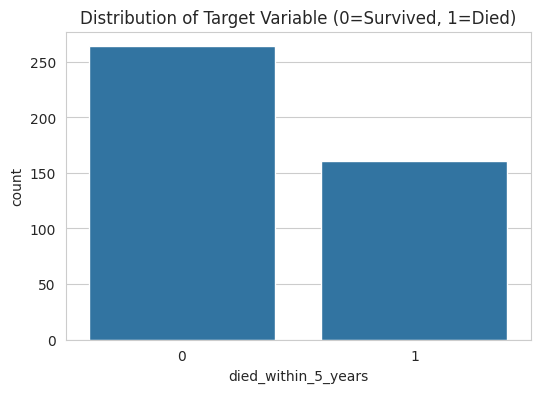

>> EDA finding: The dataset is imbalanced. 'Died' (1) is the minority class.

[EDA] Visualizing Key Features...


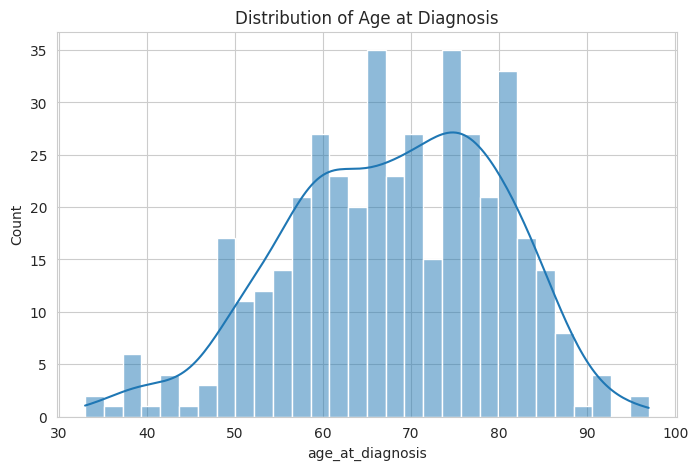

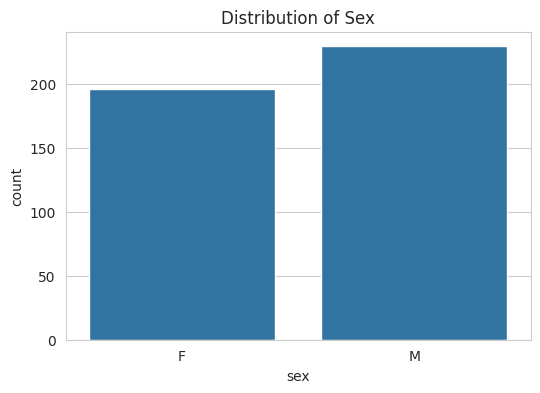

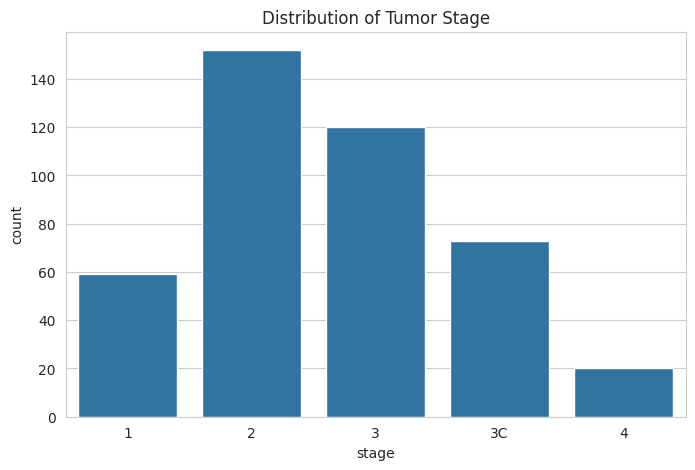


[EDA] Missing Values Count (Top 15):
pM                                                392
crc_primary_cause_of_death                        330
em_lvi_notes                                      221
distance_to_peritoneum_macroscopic_measurement     25
peri_surface_involved                               6
em_lvi                                              3
site_of_tumour_grouping                             2
site_of_tumour                                      2
tumour_type                                         2
differentiation                                     2
pre-op_radio                                        2
pre-op_chemo                                        2
pN                                                  1
pT                                                  1
stage_subgroup                                      1
dtype: int64


In [ ]:
#Part 1: Load Data and Exploratory Data Analysis (EDA)
#Before we build a model, we must understand our data.
print(f"\n--- PART 1: Load Data and Exploratory Data Analysis (EDA) ---")

#1.1: Load the Data
#We define the path to the file in your Google Drive and load it into a pandas DataFrame.
file_name = '/content/drive/My Drive/SR386_labels.csv'

try:
    df = pd.read_csv(file_name)
    print(f"Successfully loaded '{file_name}'.")
except FileNotFoundError:
    print(f"ERROR: File not found. Please ensure 'SR386_labels.csv' is in your 'My Drive' folder.")
    exit()

#1.2: Examine Data Structure
#Let's look at the first few rows (`.head()`) and the data types (`.info()`) to see what our data looks like.
print("\n[EDA] Data Head:")
print(df.head())
print("\n[EDA] Data Info:")
df.info()

#1.3: Investigate Target Variable
#Our target is 'died_within_5_years'.

#1.We see from the `.info()` and the CSV snippet that it contains string 'NULL' values.
#2.We must convert these to actual NaN (Not a Number) values.
#3.We must then *drop* these rows, as an unknown outcome is useless for training or testing our supervised model.
#4.Finally, we convert the target to a numeric type (int).
print("\n[EDA] Cleaning Target Variable 'died_within_5_years'...")
print(f"Original value counts:\n{df['died_within_5_years'].value_counts(dropna=False)}")

df['died_within_5_years'] = df['died_within_5_years'].replace('NULL', np.nan)
df.dropna(subset=['died_within_5_years'], inplace=True)
df['died_within_5_years'] = pd.to_numeric(df['died_within_5_years']).astype(int)

#1.4: Check for Class Imbalance
#Now we check the distribution of our *cleaned* target variable.
#This is critical, as an imbalanced dataset (e.g., 90% Survived, 10% Died) can bias our model.
print("\n[EDA] Cleaned target variable distribution (0=Survived, 1=Died):")
print(df['died_within_5_years'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='died_within_5_years', data=df)
plt.title('Distribution of Target Variable (0=Survived, 1=Died)')
plt.show()
print(">> EDA finding: The dataset is imbalanced. 'Died' (1) is the minority class.")

#1.5: Visualize Key Features
#Let's plot distributions for other important features.
print("\n[EDA] Visualizing Key Features...")

#Age
plt.figure(figsize=(8, 5))
sns.histplot(df['age_at_diagnosis'].dropna(), kde=True, bins=30)
plt.title('Distribution of Age at Diagnosis')
plt.show()

#Sex
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=df)
plt.title('Distribution of Sex')
plt.show()

#Tumor Stage
plt.figure(figsize=(8, 5))
sns.countplot(x='stage', data=df.sort_values('stage'))
plt.title('Distribution of Tumor Stage')
plt.show()

#1.6: Identify Missing Values
#We need to know which columns have missing data to plan our cleaning strategy.
print("\n[EDA] Missing Values Count (Top 15):")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0].sort_values(ascending=False).head(15))

In [ ]:
#Part 2: Data Cleaning and Preprocessing
#Now we prepare the data for the model.
print(f"\n--- PART 2: Data Cleaning and Preprocessing ---")

#2.1: Feature Selection
#We select features that are clinically relevant and likely predictive.
#We exclude:
#-'case_id': Just an identifier.
#-'days_till_death', 'crc_primary_cause_of_death': These are "leaky" variables; they are a direct result of the target, so using them is cheating.
#-Columns with too many missing values or free text.
features = [
    'age_at_diagnosis',
    'sex',
    'site_of_tumour_grouping',
    'kras_ex_2',
    'nras_ex_3',
    'braf_mutant_status',
    'mmr_ihc',
    'primary_metastatic',
    'stage',
    'pT',
    'pN',
    'differentiation',
    'pre-op_radio',
    'pre-op_chemo'
]
target = 'died_within_5_years'

#Separate features (X) and target (y)
X = df[features]
y = df[target]
print(f"Selected {len(features)} features. Total {len(y)} samples.")

#2.2: Split the Data (Train / Validation / Test)
#We split our data into three sets:
#-Training (70%): The model learns from this data.
#-Validation (15%): Used during training to monitor performance and check for overfitting.
#-Testing (15%): Held back until the very end. This data is used *only once* to get a final, unbiased score.

#We use `stratify=y` to ensure the imbalanced (e.g., 20% 'Died') is distributed proportionally across all three sets.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

#2.3: Define Preprocessing Pipelines
#This is the most robust way to prepare data. We create "pipelines" that will automatically handle missing values and encoding.

#Strategy Justification:
#-Numerical: We will fill missing ages with the 'median' (robust to outliers) and then 'StandardScale' the data (which ANNs require).
#-Categorical: We will fill missing categories with the 'most_frequent' value and then 'OneHotEncode' them (convert text to 0s and 1s).
print("\n[Data Prep] Defining preprocessing pipelines...")

#Identify which columns are which
numerical_features = ['age_at_diagnosis']
categorical_features = [col for col in features if col not in numerical_features]

#Create the transformer for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Create the transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

#2.4: Bundle Pipelines with ColumnTransformer
#This master tool applies the correct pipeline to the correct columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

#2.5: Apply Preprocessing
#CRITICAL: We `fit_transform` (learn and apply) on the TRAINING data.
#We ONLY `.transform` (apply the learned rules) on the validation and test data.
#This prevents data leakage.
print("[Data Prep] Applying preprocessing pipeline...")
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training set shape (features): {X_train_processed.shape[1]}")
print("Data preprocessing complete.")


--- PART 2: Data Cleaning and Preprocessing ---
Selected 14 features. Total 425 samples.
Training set shape: (297, 14)
Validation set shape: (64, 14)
Test set shape: (64, 14)

[Data Prep] Defining preprocessing pipelines...
[Data Prep] Applying preprocessing pipeline...
Processed training set shape (features): 89
Data preprocessing complete.



--- PART 3: Baseline ANN Model ---


Model: "Baseline_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 32)             │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,425 (13.38 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 0 (0.00 B)


Training Baseline Model...
Baseline Model training complete.


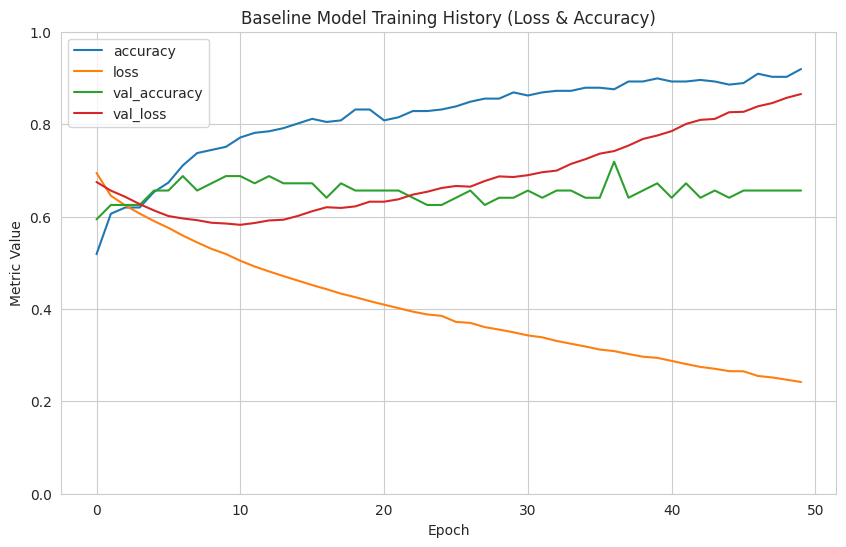

In [ ]:
#Part 3: Baseline ANN Model
#We will build a simple "baseline" model to see the performance we get without any tuning.
print(f"\n--- PART 3: Baseline ANN Model ---")

#3.1: Define the Architecture
#-Input: Shape must match our number of processed features.
#-Hidden Layers: Two layers (32 and 16 neurons) with 'ReLU' activation.
#-Output Layer: One neuron with 'sigmoid' activation (outputs a probability between 0 and 1, perfect for binary classification).
input_shape = (X_train_processed.shape[1],)

model_base = Sequential([
    Input(shape=input_shape, name='Input_Layer'),
    Dense(32, activation='relu', name='Hidden_Layer_1'),
    Dense(16, activation='relu', name='Hidden_Layer_2'),
    Dense(1, activation='sigmoid', name='Output_Layer')
], name='Baseline_Model')

model_base.summary()

#3.2: Compile the Model
#We configure the model for training.
#-Loss: 'binary_crossentropy' is the standard loss function for a two-class (yes/no) problem.
#-Optimizer: 'Adam' is a modern, effective, and popular optimizer.
model_base.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#3.3: Train the Model
#We `fit` the model on our training data.
#-We use the `validation_data` to check its performance on data it isn't learning from, which helps spot overfitting.
print("\nTraining Baseline Model...")
history_base = model_base.fit(
    X_train_processed,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_processed, y_val),
    verbose=0
#Set to 1 if you want to see epoch-by-epoch output

)
print("Baseline Model training complete.")

#3.4: Plot Training History
#We plot the training & validation loss/accuracy.
#-If training accuracy (blue) goes up while validation (orange) flattens or goes down, the model is overfitting.
pd.DataFrame(history_base.history).plot(figsize=(10, 6))
plt.grid(True)
plt.title('Baseline Model Training History (Loss & Accuracy)')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.ylim(0, 1) #Set y-axis from 0 to 1
plt.show()


--- PART 4: Baseline Model Evaluation ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


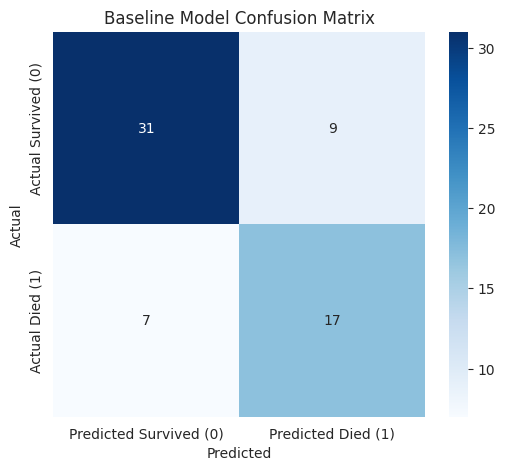


Baseline Model Key Metrics:
  Accuracy (Overall): 0.7500
  Accuracy (Class 0 'Survived'): 0.7750  <-- This is the 'Accuracy' for class 0
  Accuracy (Class 1 'Died'): 0.7083  <-- This is the 'Accuracy' for class 1
  Precision (Class 1 'Died'): 0.6538
  F1-Score (Class 1 'Died'): 0.6800

Full Classification Report (Baseline):
              precision    recall  f1-score   support

Survived (0)       0.82      0.78      0.79        40
    Died (1)       0.65      0.71      0.68        24

    accuracy                           0.75        64
   macro avg       0.73      0.74      0.74        64
weighted avg       0.76      0.75      0.75        64


--- Metric Interpretation ---
> **Context:** We are predicting 'Died (1)'.
> **Accuracy (Overall):** Overall correctness. (TP+TN) / (All)
> **Recall (Class 0 'Survived') / Specificity:** Of all patients who *actually survived*, what % did we correctly label as 'Survived'?
> **Recall (Class 1 'Died') / Sensitivity:** Of all patients who *actual

In [ ]:
#Part 4: Baseline Model Evaluation
#Now, let's see how our baseline model performs on the completely unseen test set.
print(f"\n--- PART 4: Baseline Model Evaluation ---")

#4.1: Make Predictions
#The model outputs probabilities (e.g., 0.67). We set a threshold of 0.5 to classify as 1 (Died) or 0 (Survived).
y_pred_proba_base = model_base.predict(X_test_processed)
y_pred_base = (y_pred_proba_base > 0.5).astype(int)

#4.2: Generate a Confusion Matrix
#This is the single most useful evaluation tool.
#True Neg (TN): Actual Survived (0), Predicted Survived (0) [Top-Left]
#False Pos (FP): Actual Survived (0), Predicted Died (1) [Top-Right]
#False Neg (FN): Actual Died (1), Predicted Survived (0) [Bottom-Left]
#True Pos (TP): Actual Died (1), Predicted Died (1) [Bottom-Right]
cm_base = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Survived (0)', 'Predicted Died (1)'],
            yticklabels=['Actual Survived (0)', 'Actual Died (1)'])
plt.title('Baseline Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#4.3: Calculate and Interpret Key Metrics
#We will now calculate and print the key metrics, including recall for BOTH classes (0 and 1).
print("\nBaseline Model Key Metrics:")

#Calculate overall accuracy
acc_base = accuracy_score(y_test, y_pred_base)

#Calculate metrics for Class 1 ('Died')
#'zero_division=0' prevents a warning if a class is never predicted
precision_base_c1 = precision_score(y_test, y_pred_base, pos_label=1, zero_division=0)
recall_base_c1 = recall_score(y_test, y_pred_base, pos_label=1, zero_division=0)
f1_base_c1 = f1_score(y_test, y_pred_base, pos_label=1, zero_division=0)

#Calculate metrics for Class 0 ('Survived')
#Note: Recall for class 0 is also known as "Specificity"
recall_base_c0 = recall_score(y_test, y_pred_base, pos_label=0, zero_division=0)

print(f"  Accuracy (Overall): {acc_base:.4f}")
print(f"  Accuracy (Class 0 'Survived'): {recall_base_c0:.4f}  <-- This is the 'Accuracy' for class 0")
print(f"  Accuracy (Class 1 'Died'): {recall_base_c1:.4f}  <-- This is the 'Accuracy' for class 1")
print(f"  Precision (Class 1 'Died'): {precision_base_c1:.4f}")
print(f"  F1-Score (Class 1 'Died'): {f1_base_c1:.4f}")


#We still print the full report as it provides context for BOTH classes
print("\nFull Classification Report (Baseline):")
print(classification_report(y_test, y_pred_base, target_names=['Survived (0)', 'Died (1)']))

print("\n--- Metric Interpretation ---")
print("> **Context:** We are predicting 'Died (1)'.")
print("> **Accuracy (Overall):** Overall correctness. (TP+TN) / (All)")
print("> **Recall (Class 0 'Survived') / Specificity:** Of all patients who *actually survived*, what % did we correctly label as 'Survived'?")
print("> **Recall (Class 1 'Died') / Sensitivity:** Of all patients who *actually died*, what % did we correctly label as 'Died'?")
print("> **Precision (for 'Died'):** When the model predicts 'Died', how often is it right? (TP / (TP+FP))")
print("\n> **Clinical Implications (False Positives vs. False Negatives):**")
print("> - **False Positive (FP):** Model predicts 'Died', patient 'Survived'.")
print(">   - **Cost:** Unnecessary emotional distress, potentially overly aggressive (and costly/risky) treatment.")
print("> - **False Negative (FN):** Model predicts 'Survived', patient 'Died'.")
print(">   - **Cost:** **This is the worse error.** A patient is told they are low-risk and may not receive aggressive-enough treatment or follow-up, leading to a preventable death.")
print("> **Conclusion:** We MUST improve **Recall (Sensitivity)** for the 'Died (1)' class.")

In [ ]:
#Part 5: Model Improvement
print(f"\n--- PART 5: Model Improvement ---")
print(f"Goal: Improve the baseline Recall for 'Died (1)'.")

#Improvement 1: Address Class Imbalance (SMOTE)
#Our EDA showed an imbalanced dataset. This can cause the model to just predict "Survived" (the majority class) all the time.
#SMOTE (Synthetic Minority Over-sampling Technique) will create new "synthetic" examples of the minority class ('Died') in the *training set* to create a balanced dataset for the model to learn from.
print("\n--- Improvement 1: Training with SMOTE (Oversampling) ---")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f"Original training distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nSMOTE-balanced training distribution:\n{y_train_smote.value_counts(normalize=True)}")

#We must define a new model (re-initialize weights)
model_smote = Sequential([
    Input(shape=input_shape),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
], name='SMOTE_Model')
model_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train on the new SMOTE data
print("Training SMOTE Model...")
history_smote = model_smote.fit(
    X_train_smote,
    y_train_smote,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_processed, y_val),
    verbose=0
)
print("SMOTE Model training complete.")

#Evaluate SMOTE Model on the original test set
print("\nSMOTE Model Evaluation:")
y_pred_proba_smote = model_smote.predict(X_test_processed)
y_pred_smote = (y_pred_proba_smote > 0.5).astype(int)
print(classification_report(y_test, y_pred_smote, target_names=['Survived (0)', 'Died (1)']))
print(">> Check if Recall for 'Died (1)' improved.")

#Improvement 2: Regularization (Dropout)
#Another common problem is "overfitting" (where the model memorizes the training data but fails on new data).
#Dropout layers "turn off" a random fraction of neurons during training, forcing the network to learn more robust patterns.
print("\n--- Improvement 2: Training with Dropout (Regularization) ---")
#We will add Dropout(0.3) = 30% dropout after our hidden layers.
#We train this on the *original* (imbalanced) data.
model_dropout = Sequential([
    Input(shape=input_shape),
    Dense(32, activation='relu'),
    Dropout(0.3),#Add Dropout layer
    Dense(16, activation='relu'),
    Dropout(0.3),#Add Dropout layer
    Dense(1, activation='sigmoid')
], name='Dropout_Model')
model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the Dropout model
print("Training Dropout Model...")
history_dropout = model_dropout.fit(
    X_train_processed,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_processed, y_val),
    verbose=0
)
print("Dropout Model training complete.")

#Evaluate Dropout Model on the original test set
print("\nDropout Model Evaluation:")
y_pred_proba_dropout = model_dropout.predict(X_test_processed)
y_pred_dropout = (y_pred_proba_dropout > 0.5).astype(int)
print(classification_report(y_test, y_pred_dropout, target_names=['Survived (0)', 'Died (1)']))
print(">> Check if metrics improved.")


--- PART 5: Model Improvement ---
Goal: Improve the baseline Recall for 'Died (1)'.

--- Improvement 1: Training with SMOTE (Oversampling) ---
Original training distribution:
died_within_5_years
0    0.619529
1    0.380471
Name: proportion, dtype: float64

SMOTE-balanced training distribution:
died_within_5_years
0    0.5
1    0.5
Name: proportion, dtype: float64
Training SMOTE Model...
SMOTE Model training complete.

SMOTE Model Evaluation:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
              precision    recall  f1-score   support

Survived (0)       0.79      0.75      0.77        40
    Died (1)       0.62      0.67      0.64        24

    accuracy                           0.72        64
   macro avg       0.70      0.71      0.70        64
weighted avg       0.72      0.72      0.72        64

>> Check if Recall for 'Died (1)' improved.

--- Improvement 2: Training with Dropout (Regularization) ---
Training Dropout Model...
Dropout Model training complete.

Dropout Model Evaluat

In [ ]:
#Part 6: Final Performance Comparison
#Let's put the metrics from all three models side-by-side to declare a winner.
print(f"\n--- PART 6: Final Performance Comparison ---")

#Helper function to get a clean dictionary of metrics, focusing on the 'Died (1)' class (pos_label=1).
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    return {
        "Accuracy (Overall)": acc,
        "Precision (Class 1)": precision,
        "Recall (Class 1)": recall,
        "F1-Score (Class 1)": f1
    }

#Calculate metrics for all models
metrics_base = get_metrics(y_test, y_pred_base)
metrics_smote = get_metrics(y_test, y_pred_smote)
metrics_dropout = get_metrics(y_test, y_pred_dropout)

#Create a comparison DataFrame
comparison_df = pd.DataFrame([metrics_base, metrics_smote, metrics_dropout],
                             index=['Baseline', 'SMOTE', 'Dropout'])

print("\nFinal Model Comparison Table (Metrics for 'Died (1)' class):")
print(comparison_df.round(4))


--- PART 6: Final Performance Comparison ---

Final Model Comparison Table (Metrics for 'Died (1)' class):
          Accuracy (Overall)  Precision (Class 1)  Recall (Class 1)  \
Baseline              0.7500               0.6538            0.7083   
SMOTE                 0.7188               0.6154            0.6667   
Dropout               0.7188               0.6364            0.5833   

          F1-Score (Class 1)  
Baseline              0.6800  
SMOTE                 0.6400  
Dropout               0.6087  
